# Demo of Prox Soft Body Simulator: Contraction

In [1]:
%matplotlib widget

First we make sure to import all modules that is needed.

In [2]:
import numpy as np
import isl.math.vector3 as V3
import isl.geometry.volume_mesh as VM
import isl.simulators.prox_soft_bodies.api as API
import isl.simulators.prox_soft_bodies.solver as SOLVER
import isl.util.viewer as VIEWER

Second we set up a test scene using a simple beam shape. In this setup all external forces are turned off, no gravity or damping forces, only elastic forces are effective. The beam is initially at rest and initialized with an initial deformation forcing it to contract along the x-axis. Hence, we should expect to see a beam that will oscillate in "width" when simulation starts.

In [3]:
V, T = VM.create_beam(7, 7, 7, 1.0, 1.0, 1.0)

engine = API.create_engine()
engine.params.time_step = 0.001

API.create_material(engine, 'mat')
API.set_elasticity(engine, 'mat', 100000.0, 0.3)
API.set_mass_density(engine, 'mat', 500.0)
API.set_constitutive_model(engine, 'mat', API.SVK)
API.set_viscosity(engine, 'mat', 0.0)   # No viscosity forces
API.create_surfaces_interaction(engine,'mat','mat', 0.5)

API.create_soft_body(engine, 'cube', V, T)
API.set_type(engine, 'cube', 'Free')
API.set_gravity(engine, 'cube', (0,0,0))  #No gravity forces
API.set_material(engine,'cube','mat')

# Create an initial deformation, so beam will contract it self along x-axis.
x = API.get_material_coordinates(engine, 'cube')
x[:,0] = 1.2*x[:,0]
API.set_spatial_coordinates(engine,'cube',x)

Next we create a viewer object that will be responsible for showing the animation. We need an auxiliary function that can take contact point data out of the engine and into the viewer.

Once we got this in place then we can create a simulation loop and start the simulation.

In [4]:
viewer = VIEWER.Viewer()
for body in engine.bodies.values():
    opacity = 0.5
    color = V3.make(1.0,0.1,0.1)
    F = VM.to_triangles(body.T)
    viewer.create_mesh(body.name, body.x, F, color, opacity)

def simulation(viewer, engine, monitor=True):
    dt = engine.params.time_step
    T  = 1.0
    fps = 1.0/dt
    steps = int(np.round(T*fps))    
    for i in range(steps):
        for body in engine.bodies.values():
            viewer.update_mesh(body.name, body.x)
        API.simulate(engine, dt, monitor)
    return API.get_log(engine)
        
viewer.show()
stats = simulation(viewer, engine, True)

/Users/kenny/opt/anaconda3/envs/cmis/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(color='white', intensity=0.6, positi…

/Users/kenny/opt/anaconda3/envs/cmis/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/kenny/opt/anaconda3/envs/cmis/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


The stepper function in the SOLVER module is the main work horse of the simulation. It outputs a lot of statistics about the numerics. This data is useful to analyze what happend in the simulation and if the simulator was working or if something unexpected happend.

Often one cares about the convergence of the solver. It is not difficult to extract and plot the convergence rates.

In [5]:
import matplotlib.pyplot as plt

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
          '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
          '#000075', '#808080', '#ffffff', '#000000']

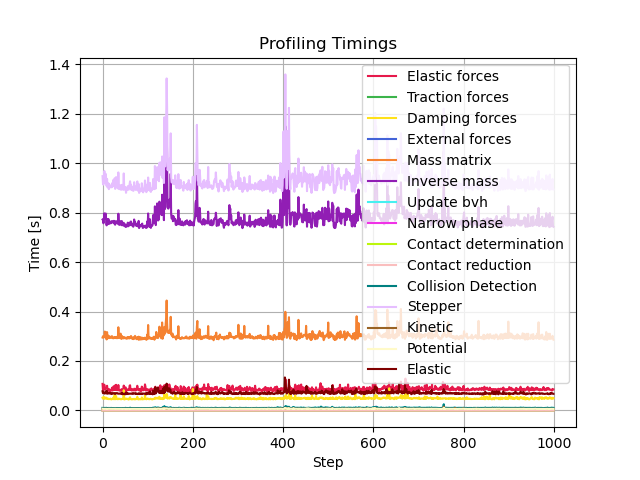

In [6]:
time_elastic_forces = [ stats[i]['compute_elastic_forces'] for i in range(len(stats)) ]
time_traction_forces = [ stats[i]['compute_traction_forces'] for i in range(len(stats)) ]
time_damping_forces = [ stats[i]['compute_damping_forces'] for i in range(len(stats)) ]
time_external_forces = [ stats[i]['compute_external_forces'] for i in range(len(stats)) ]
time_mass_matrix = [ stats[i]['compute_mass_matrix'] for i in range(len(stats)) ]
time_inverse_mass_matrix = [ stats[i]['compute_inverse_mass_matrix'] for i in range(len(stats)) ]
time_update_bvh = [ stats[i]['update_bvh'] for i in range(len(stats)) ]
time_narrow_phase = [ stats[i]['narrow_phase'] for i in range(len(stats)) ]
time_contact_determination = [ stats[i]['contact_determination'] for i in range(len(stats)) ]
time_contact_point_reduction = [ stats[i]['contact_point_reduction'] for i in range(len(stats)) ]
time_collision_detection = [ stats[i]['collision_detection_time'] for i in range(len(stats)) ]
time_stepper = [ stats[i]['stepper_time'] for i in range(len(stats)) ]
time_kinetic_energy = [ stats[i]['compute_kinetic_energy'] for i in range(len(stats)) ]
time_poential_energy = [ stats[i]['compute_potential_energy'] for i in range(len(stats)) ]
time_elastic_energy = [ stats[i]['compute_elastic_energy'] for i in range(len(stats)) ]

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Profiling Timings')
ax.set_xlabel('Step')
ax.set_ylabel('Time [s]')
plt.grid(True)
ax.plot(time_elastic_forces, label='Elastic forces', color=colors[0])
ax.plot(time_traction_forces, label='Traction forces', color=colors[1])
ax.plot(time_damping_forces, label='Damping forces', color=colors[2])
ax.plot(time_external_forces, label='External forces', color=colors[3])
ax.plot(time_mass_matrix, label='Mass matrix', color=colors[4])
ax.plot(time_inverse_mass_matrix, label='Inverse mass', color=colors[5])
ax.plot(time_update_bvh, label='Update bvh', color=colors[6])
ax.plot(time_narrow_phase, label='Narrow phase', color=colors[7])
ax.plot(time_contact_determination, label='Contact determination', color=colors[8])
ax.plot(time_contact_point_reduction, label='Contact reduction', color=colors[9])
ax.plot(time_collision_detection, label='Collision Detection', color=colors[10])
ax.plot(time_stepper, label='Stepper', color=colors[11])
ax.plot(time_kinetic_energy, label='Kinetic', color=colors[12])
ax.plot(time_poential_energy, label='Potential', color=colors[13])
ax.plot(time_elastic_energy, label='Elastic', color=colors[14])
ax.legend()
plt.show()

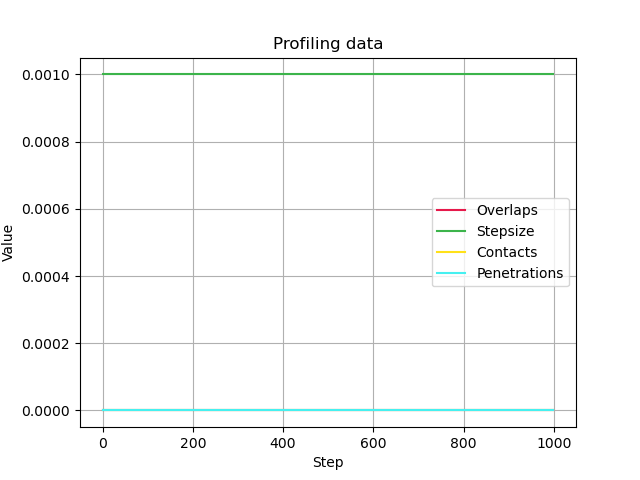

In [7]:
number_of_overlaps = [ stats[i]['number_of_overlaps'] for i in range(len(stats)) ]
step_sizes = [ stats[i]['dt'] for i in range(len(stats)) ]
number_of_contact_points = [ stats[i]['contact_points'] for i in range(len(stats)) ]
penetrations = [ stats[i]['max_penetration'] for i in range(len(stats)) ]

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Profiling data')
ax.set_xlabel('Step')
ax.set_ylabel('Value')
plt.grid(True)
ax.plot(number_of_overlaps, label='Overlaps', color=colors[0])
ax.plot(step_sizes, label='Stepsize', color=colors[1])
ax.plot(number_of_contact_points, label='Contacts', color=colors[2])
ax.plot(penetrations, label='Penetrations', color=colors[6])
ax.legend()
plt.show()

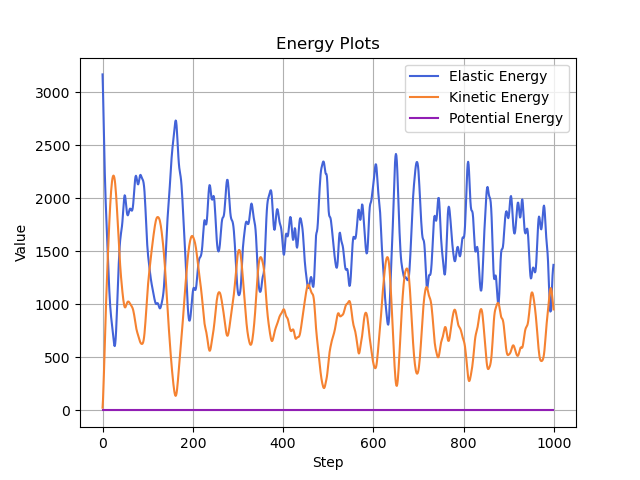

In [8]:
elastic_energy = [ stats[i]['elastic_energy'] for i in range(len(stats)) ]
kinetic_energy = [ stats[i]['kinetic_energy'] for i in range(len(stats)) ]
potential_energy = [ stats[i]['potential_energy'] for i in range(len(stats)) ]

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Energy Plots')
ax.set_xlabel('Step')
ax.set_ylabel('Value')
plt.grid(True)
ax.plot(elastic_energy, label='Elastic Energy', color=colors[3])
ax.plot(kinetic_energy, label='Kinetic Energy', color=colors[4])
ax.plot(potential_energy, label='Potential Energy', color=colors[5])
ax.legend()
plt.show()